In [1]:
# Dublin Business School
# @author: Juliana Salvadori
# @Student_number: 10521647
# @Assigment: CA2 - Regression model

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as pyplot  
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split , KFold 
from sklearn.linear_model import LinearRegression  
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.neural_network import MLPRegressor 

In [4]:
'''
Load data
######################################
'''
file_name='movies.csv'
data = pd.read_csv(file_name)

In [5]:
# set options to display all columns of the dataset
pd.options.display.max_columns = data.shape[1]

In [6]:
'''
Quick Glance
######################################
'''
view = data.head(10)
print(view)

   year       imdb                   title             test clean_test binary  \
0  2013  tt1711425           21 &amp; Over           notalk     notalk   FAIL   
1  2012  tt1343727                Dredd 3D      ok-disagree         ok   PASS   
2  2013  tt2024544        12 Years a Slave  notalk-disagree     notalk   FAIL   
3  2013  tt1272878                  2 Guns           notalk     notalk   FAIL   
4  2013  tt0453562                      42              men        men   FAIL   
5  2013  tt1335975                47 Ronin              men        men   FAIL   
6  2013  tt1606378  A Good Day to Die Hard           notalk     notalk   FAIL   
7  2013  tt2194499              About Time      ok-disagree         ok   PASS   
8  2013  tt1814621               Admission               ok         ok   PASS   
9  2013  tt1815862             After Earth           notalk     notalk   FAIL   

      budget    domgross     intgross      code  budget_2013$  domgross_2013$  \
0   13000000  25682380.0   

In [7]:
# The data looks ok, it does not show too many missing values
# and the continuous are in the same scale

In [8]:
'''
Review Dimensions of the data
######################################
'''
dim = data.shape
print(dim)

(1794, 15)


In [9]:
# dataset has 1794 rows and 15 columns (14 features and 1 target)

In [10]:
'''
Clean data
######################################
'''
# let's check how many NaN values for each feature
data.isnull().sum()

year                0
imdb                0
title               0
test                0
clean_test          0
binary              0
budget              0
domgross           17
intgross           11
code                0
budget_2013$        0
domgross_2013$     18
intgross_2013$     11
period code       179
decade code       179
dtype: int64

In [11]:
# let's check the impact on the dataset size if the lines with NA values are removed
print(len(data.dropna()))

1600


In [12]:
# the dataset will be reduced to 1600 rows, which is fine
# so, there is no need to keep those values and work with
# imputation methods

In [13]:
data = data.dropna()
# check that none NaN values was left
data.isnull().sum()

year              0
imdb              0
title             0
test              0
clean_test        0
binary            0
budget            0
domgross          0
intgross          0
code              0
budget_2013$      0
domgross_2013$    0
intgross_2013$    0
period code       0
decade code       0
dtype: int64

In [14]:
# check new dimensions
dim = data.shape
print(dim)

(1600, 15)


In [15]:
'''
Review data types
######################################
'''
types = data.dtypes
print(types)

year                int64
imdb               object
title              object
test               object
clean_test         object
binary             object
budget              int64
domgross          float64
intgross          float64
code               object
budget_2013$        int64
domgross_2013$    float64
intgross_2013$    float64
period code       float64
decade code       float64
dtype: object


In [16]:
# Note that the data type for one of the features that will be used (binary) is object (string)
# So, I will need to convert that to integer values

In [17]:
'''
Class distribution
######################################
'''
# binary
binary_count = data.groupby('binary').size()
print (binary_count)

binary
FAIL    856
PASS    744
dtype: int64


In [18]:
def set_binary_int (row):
   if row['binary'] == 'PASS':
      return 1
   return 0

In [19]:
data["binary_int"]  = data.apply (lambda row: set_binary_int(row), axis=1)

In [20]:
view = data.loc[ :, ['binary', 'binary_int']]
print(view.head(10))

  binary  binary_int
0   FAIL           0
1   PASS           1
2   FAIL           0
3   FAIL           0
4   FAIL           0
5   FAIL           0
6   FAIL           0
7   PASS           1
8   PASS           1
9   FAIL           0


In [21]:
binary_count = data.groupby('binary_int').size()
print (binary_count)

binary_int
0    856
1    744
dtype: int64


In [22]:
'''
Data Description
######################################
'''
# limiting the results up to two possible digits after decimals 
pd.set_option('precision', 2)

In [23]:
# lists the number of non-null values and the datatype of each variable.
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1600 entries, 0 to 1614
Data columns (total 16 columns):
year              1600 non-null int64
imdb              1600 non-null object
title             1600 non-null object
test              1600 non-null object
clean_test        1600 non-null object
binary            1600 non-null object
budget            1600 non-null int64
domgross          1600 non-null float64
intgross          1600 non-null float64
code              1600 non-null object
budget_2013$      1600 non-null int64
domgross_2013$    1600 non-null float64
intgross_2013$    1600 non-null float64
period code       1600 non-null float64
decade code       1600 non-null float64
binary_int        1600 non-null int64
dtypes: float64(6), int64(4), object(6)
memory usage: 175.0+ KB


In [24]:
# it shows that at this stage there is no NaN values 

In [25]:
# summary of statistics for the given dataset
description = data.describe()
print(description)

          year    budget  domgross  intgross  budget_2013$  domgross_2013$  \
count  1600.00  1.60e+03  1.60e+03  1.60e+03      1.60e+03        1.60e+03   
mean   2004.80  4.84e+07  6.93e+07  1.56e+08      5.75e+07        8.42e+07   
std       5.86  4.96e+07  8.08e+07  2.16e+08      5.61e+07        9.90e+07   
min    1990.00  7.00e+03  8.28e+02  8.28e+02      8.63e+03        8.99e+02   
25%    2000.75  1.40e+07  1.63e+07  2.70e+07      1.66e+07        1.90e+07   
50%    2006.00  3.00e+07  4.26e+07  8.07e+07      3.80e+07        5.23e+07   
75%    2010.00  6.56e+07  9.38e+07  1.99e+08      8.43e+07        1.12e+08   
max    2013.00  4.25e+08  7.61e+08  2.78e+09      4.61e+08        9.56e+08   

       intgross_2013$  period code  decade code  binary_int  
count        1.60e+03      1600.00      1600.00     1600.00  
mean         1.87e+08         2.43         1.94        0.47  
std          2.59e+08         1.20         0.69        0.50  
min          8.99e+02         1.00         1.00  

In [26]:
# it shows that the target variable (budget_2013$) and features (domgross_2013$,intgross_2013$,binary_int)
# have no negative or NaN values

In [27]:
'''
Correlations between Target and Feature
######################################
'''
columns = ['binary_int','budget_2013$','domgross_2013$','intgross_2013$']
correlations = data[columns].corr()
print(correlations)

                binary_int  budget_2013$  domgross_2013$  intgross_2013$
binary_int            1.00         -0.17           -0.07           -0.08
budget_2013$         -0.17          1.00            0.64            0.69
domgross_2013$       -0.07          0.64            1.00            0.95
intgross_2013$       -0.08          0.69            0.95            1.00


In [28]:
'''
Rescaling data
######################################
'''
# There is a need for rescaling because the feature binary_int is in a different scale
x_feature = ['binary_int','domgross_2013$', 'intgross_2013$']
y_target  = ['budget_2013$']

x = data[x_feature].values
scale = MinMaxScaler (feature_range = (0,2))
rescaled_data = scale.fit_transform(x)

In [29]:
np.set_printoptions(precision=3)

In [30]:
print(rescaled_data[0:5,:])

[[0.    0.054 0.027]
 [2.    0.028 0.026]
 [0.    0.111 0.1  ]
 [0.    0.158 0.084]
 [0.    0.199 0.06 ]]


In [31]:
print(rescaled_data.shape)

(1600, 3)


In [32]:
# set up x and y to be used on the test/train process
x = rescaled_data
y = data[y_target].values

In [33]:
'''
Applying Linear regression
######################################
'''
# Splitting the dataset into training and test set
x_train, x_test, y_train, y_test= train_test_split(x, y, test_size= 0.2, random_state=0)  

In [34]:
print(len(x_test))   # 320  (20%)
print(len(y_test))

320
320


In [35]:
print(len(x_train))  # 1280 (80%)
print(len(y_train))

1280
1280


In [36]:
# Fitting the model to the training set
model = LinearRegression()  
model.fit(x_train, y_train)  

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [37]:
# Checking the performance of the model by predicting the test set result
y_pred = model.predict(x_test)  
print(len(y_pred))

320


In [38]:
# Mean squared error
test_set_rmse = (np.sqrt(mean_squared_error(y_test, y_pred)))
print('Mean squared error:',test_set_rmse)

Mean squared error: 41063032.86551617


In [ ]:
# The mean squared error is really high which indicates the model is not good and leads to underfitting error.

In [39]:
# R square
test_set_r2   = r2_score(y_test, y_pred)
print('Variance score:',test_set_r2)

Variance score: 0.40797528086306045


In [41]:
'''
KFolds cross-validation to evaluate the model
######################################
'''
kf = KFold (n_splits=20)
list_training_error = []
list_testing_error = []

In [42]:
for train_idx, test_idx in kf.split(x):
    # 
    x_train, x_test = x[train_idx], x[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    
    # fit the model
    model = MLPRegressor()
    model.fit(x_train, y_train)
    
    # prediction
    y_train_pred = model.predict(x_train)
    y_test_pred  = model.predict(x_test)
    
    # estimate the errors for test and training sets
    fold_training_error = mean_absolute_error(y_train, y_train_pred) 
    fold_testing_error = mean_absolute_error(y_test, y_test_pred)
    
    list_training_error.append(fold_training_error)
    list_testing_error.append(fold_testing_error)

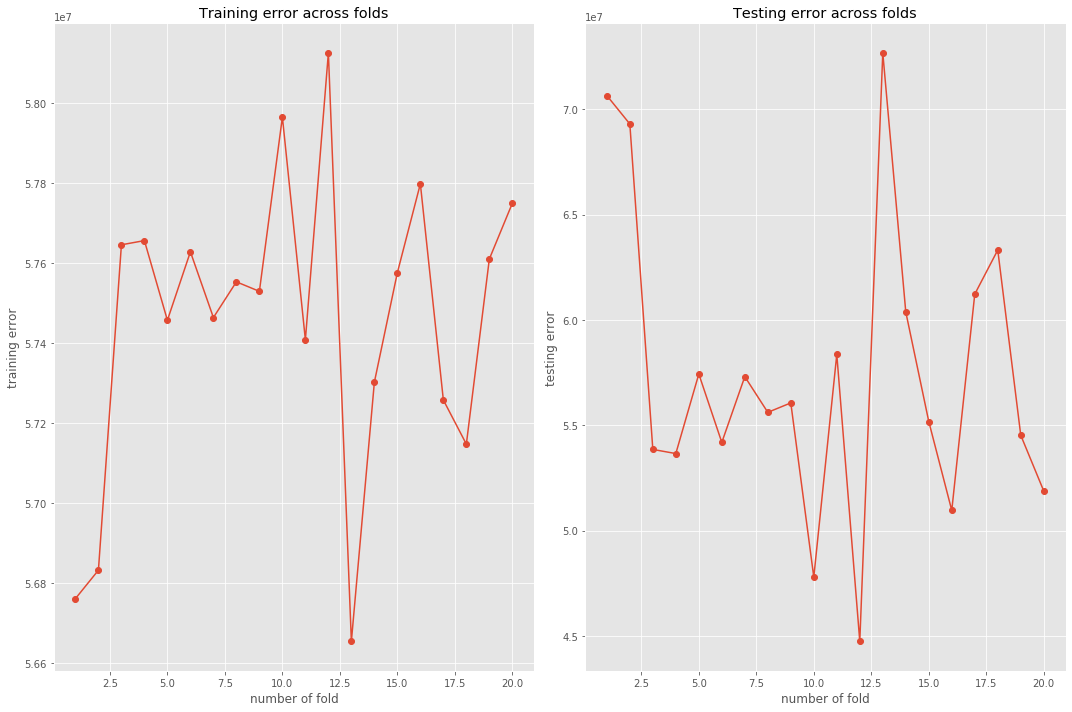

In [43]:
pyplot.style.use('ggplot')    
pyplot.figure( figsize=(15,10))
pyplot.subplot(1,2,1)
pyplot.plot(range(1, kf.get_n_splits() + 1), np.array(list_training_error).ravel(), 'o-')
pyplot.xlabel('number of fold')
pyplot.ylabel('training error')
pyplot.title('Training error across folds')
pyplot.tight_layout()
pyplot.subplot(1,2,2)
pyplot.plot(range(1, kf.get_n_splits() + 1), np.array(list_testing_error).ravel(), 'o-')
pyplot.xlabel('number of fold')
pyplot.ylabel('testing error')
pyplot.title('Testing error across folds')
pyplot.tight_layout()
pyplot.show()

In [44]:
# We can see that around fold 12.5 both training and test errors are very high at the same time.